<h1>1 Constructing the matrix X</h1>

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import lsqr
from scipy.sparse import csc_matrix

In [41]:
# Load the provided data
alphas_77 = np.load('hs_tomography/alphas_77.npy')
y_77 = np.load('hs_tomography/y_77.npy')
X_77 = np.load('hs_tomography/X_77.npy', allow_pickle=True)
X_example = np.load('hs_tomography/X_example.npy', allow_pickle=True)

alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')

In [42]:
def round_up_to_odd(value):
    return int(np.ceil(value) // 2 * 2 + 1)

def construct_X(M, alphas, Np=None):

    if Np is None:
        Np = round_up_to_odd(np.sqrt(2) * M)

    # Convert angles from degrees to radians
    rads = np.deg2rad(alphas)
    No = len(alphas)
    
    # Generate a meshgrid for pixel coordinates
    c = np.mgrid[-M/2+0.5:M/2,-M/2+0.5:M/2]
    c[:] = -c[0],c[1] # Pixel numbering starts from top-left corner
    c = np.reshape(c,(2,M**2)) # Flatten the grid to get x and y coordinates of each pixel
    C = np.zeros((No,2,M**2))
    C[:] = c

    # Normal vector and distance from the center of the sensor to the 0th sensor position
    n = np.array([np.sin(rads), np.cos(rads)])
    s0 = np.sqrt(2) * (M/2 - 0.5)
    
    # Compute the positions of beams on the sensor for various angles
    p = np.multiply(C[:, 0, :].T, n[0]).T + np.multiply(C[:, 1, :].T, n[1]).T + s0
    
    # Sensor step size
    sensor_step = 2 * s0 / (Np - 1)
    
    # Normalize positions into sensor units
    positions = p / sensor_step
    
    # Determine indices of sensors hit by the beams
    left_indices = np.floor(positions)
    right_indices = left_indices + 1
    
    # Concatenate indices
    indices = np.concatenate((left_indices, right_indices), axis=1)
    
    # Adjust indices based on angle offsets
    for i in range(No):
        indices[i, :] = indices[i, :] + Np * i
    
    # Calculate weights for each pixel
    right_weight = positions - np.floor(positions)
    left_weight = 1 - right_weight
    weights = np.concatenate((left_weight, right_weight), axis=1).flatten()
    
    # Filter indices by weight
    i_indices = indices.flatten()[weights != 0]
    
    # Define j_indices based on structure
    j_indices = np.zeros((No, 2, M**2))
    j_indices[:, :] = np.arange(M**2)
    j_indices = j_indices.flatten()[weights != 0]
    
    # Filter weights
    weights = weights[weights != 0]
    
    # Create sparse matrix
    X_sparse = coo_matrix((weights, (i_indices, j_indices)), shape=(Np * No, M**2))
    return X_sparse


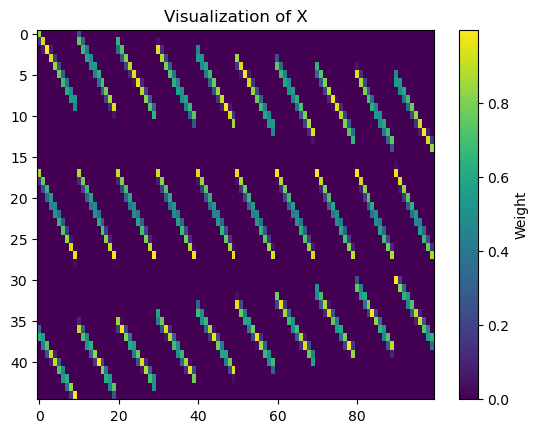

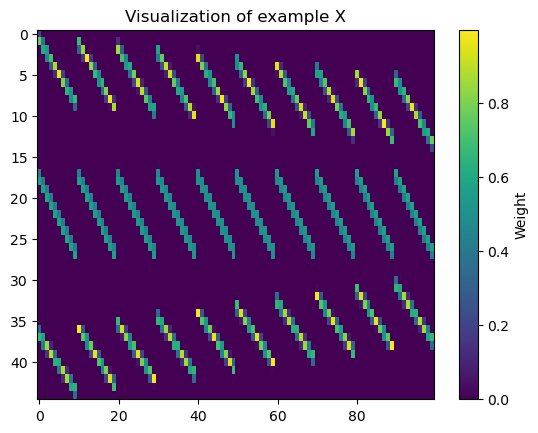

In [43]:
X = construct_X(M=10, alphas=[-33, 1, 42], Np=15)
dense_X = X.toarray()

plt.imshow(dense_X, aspect='auto')
plt.title("Visualization of X")
plt.colorbar(label='Weight')
plt.show()

plt.imshow(X_example, aspect='auto')
plt.title("Visualization of example X")

plt.colorbar(label='Weight')
plt.show()

The constructed X looks pretty similar to the example X.

<h1>2 Recovering the image</h1>

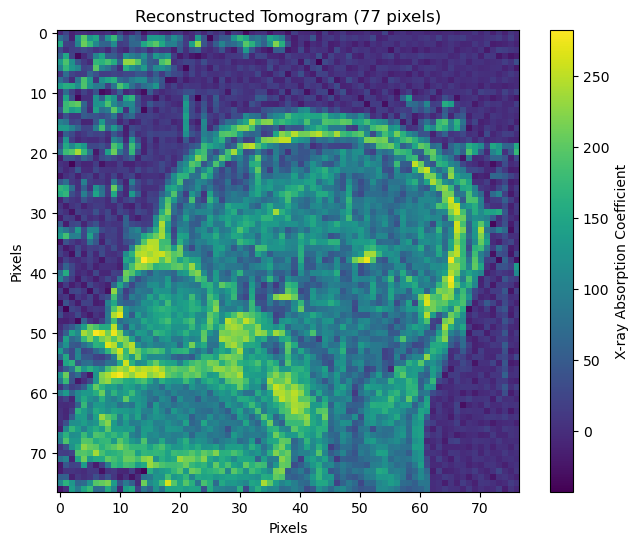

Amount of non-zero elements in X: 1066862
Sparsity: 0.9816575312107303


In [44]:
M = 77
Np = 109
X = construct_X(M, alphas_77, Np)
# Convert to CSC format for efficient computation
X_sparse = X.tocsc()
beta, _, _, _, _, _, _, _, _, _ = lsqr(X_sparse, y_77, atol=1e-03, btol=1e-03)

# Reshape beta into a 2D image
beta_image = beta.reshape(M, M)

# Display the reconstructed tomogram
plt.figure(figsize=(8, 6))
plt.imshow(beta_image)
plt.title("Reconstructed Tomogram (77 pixels)")
plt.colorbar(label='X-ray Absorption Coefficient')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

print("Amount of non-zero elements in X:", X.nnz)
print("Sparsity:", (np.prod(X.shape)-X.nnz)/np.prod(X.shape))

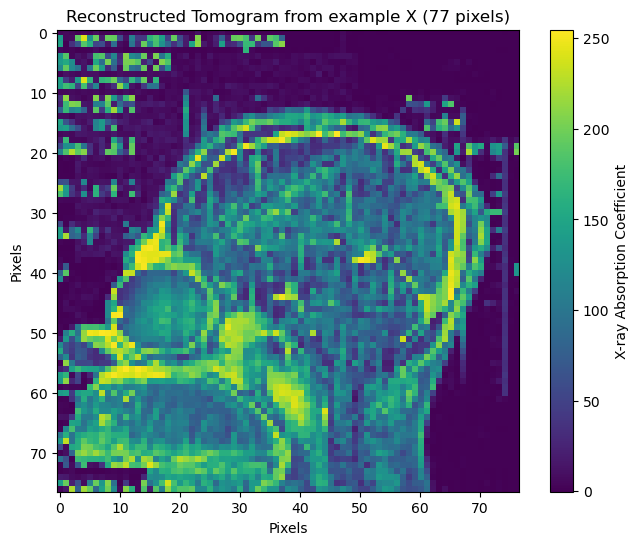

In [45]:
M = 77
Np = 109
# Convert to CSC format for efficient computation
X_sparse = csc_matrix(X_77.all())
beta, _, _, _, _, _, _, _, _, _ = lsqr(X_sparse, y_77, atol=1e-08, btol=1e-08)

# Reshape beta to 2D image format
beta_image = beta.reshape(M, M)

# Display the reconstructed tomogram
plt.figure(figsize=(8, 6))
plt.imshow(beta_image)
plt.title("Reconstructed Tomogram from example X (77 pixels)")
plt.colorbar(label='X-ray Absorption Coefficient')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

The images look pretty similar.

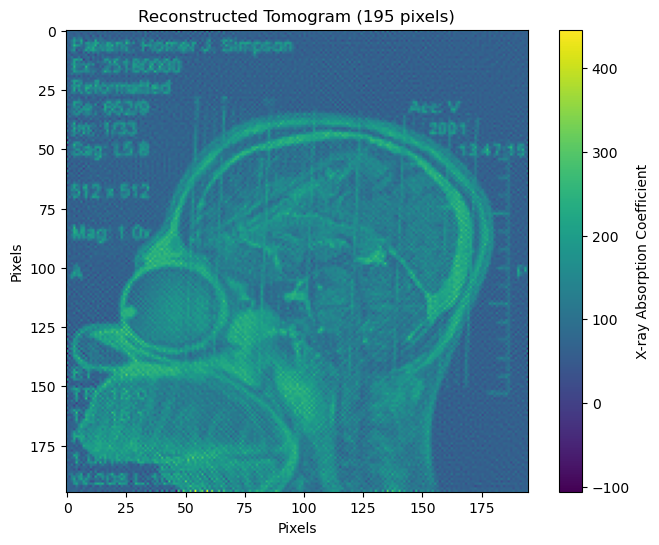

Amount of non-zero elements in X: 13611991
Sparsity: 0.9927277850736381


In [46]:
M = 195
Np = 275
X = construct_X(M, alphas_195, Np)
# Convert to CSC format for efficient computation
X_sparse = X.tocsc()
beta, _, _, _, _, _, _, _, _, _ = lsqr(X_sparse, y_195, atol=1e-04, btol=1e-04)

# Reshape beta to 2D image format
beta_image = beta.reshape(M, M)

# Display the reconstructed tomogram
plt.figure(figsize=(8, 6))
plt.imshow(beta_image)
plt.title("Reconstructed Tomogram (195 pixels)")
plt.colorbar(label='X-ray Absorption Coefficient')
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.show()

print("Amount of non-zero elements in X:", X.nnz)
print("Sparsity:", (np.prod(X.shape)-X.nnz)/np.prod(X.shape))

The patient's headaches appear to be caused by a crayon lodged in his brain. Surgical removal is advised. For long-term success, we recommend Homer refrain from inserting objects into his nose.

<h1>3 Minimizing the radiation dose</h1>

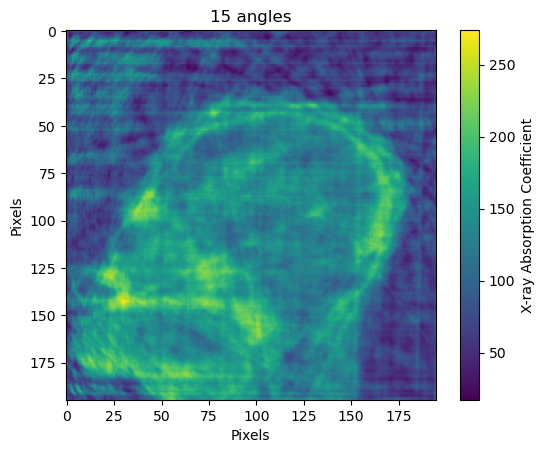

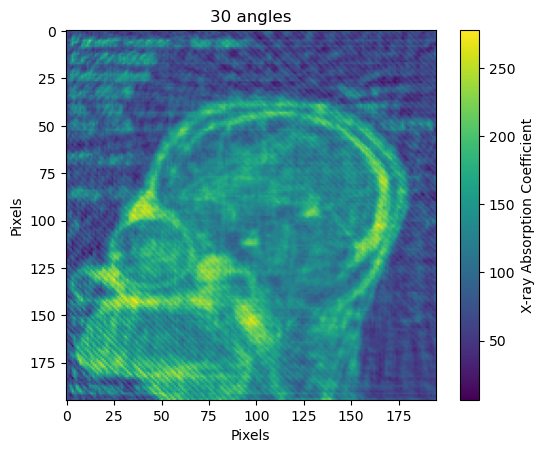

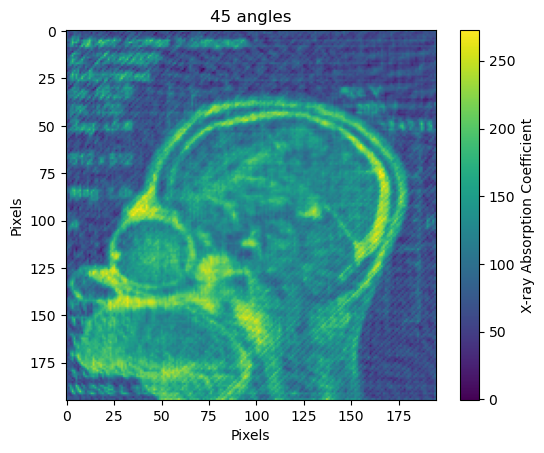

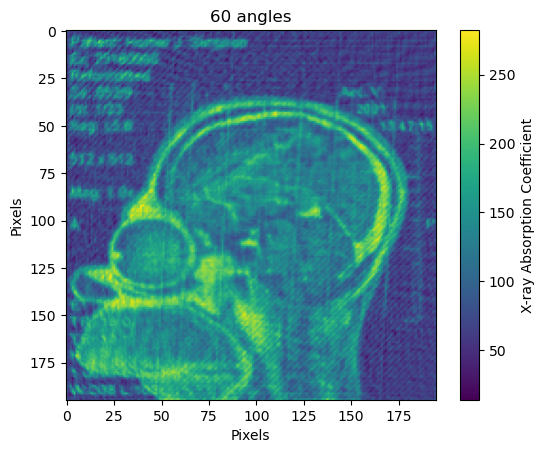

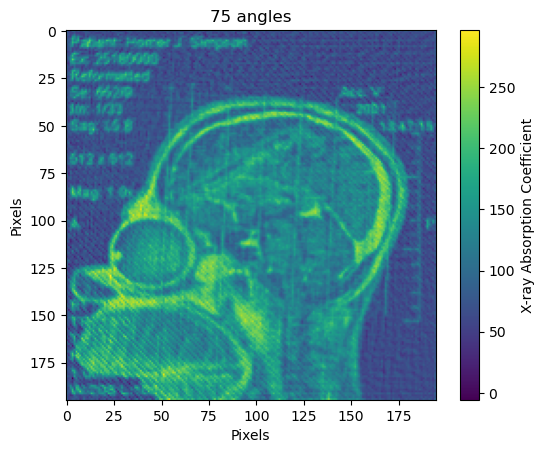

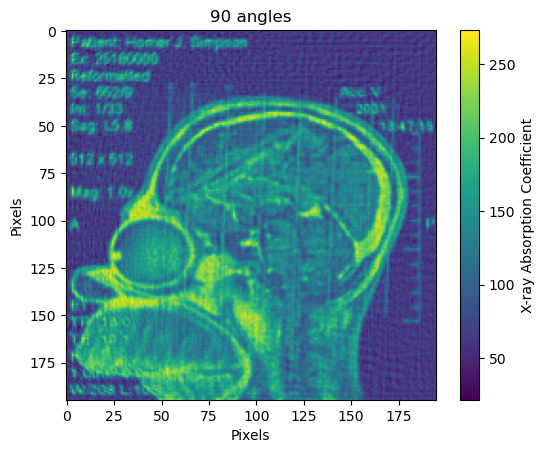

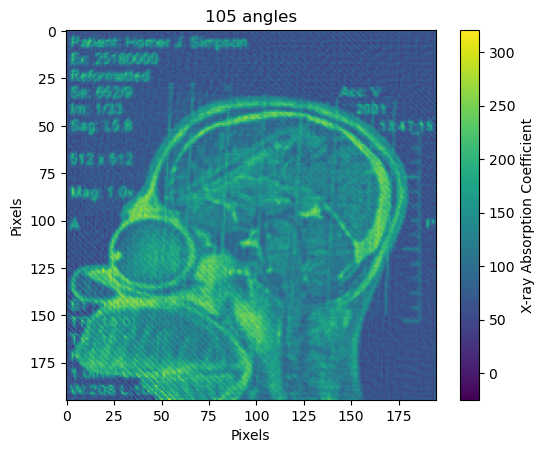

In [49]:
M = 195
Np = 275

# Define the desired number of angles
num_angles = [15, 30, 45, 60, 75, 90, 105]
for angles in num_angles:
    # Select evenly spaced indices from alphas_195
    idx = np.round(np.linspace(0, len(alphas_195) - 1, angles)).astype(int)
    alphas_selected = alphas_195[idx]

    # Select from y values accordingly
    y_selected = np.concatenate([y_195[i * Np: (i + 1) * Np] for i in idx])
    
    # Construct the X matrix
    X = construct_X(M, alphas_selected, Np)

    # Convert X to CSC format for efficient computation
    X_csc = X.tocsc()
    beta, _, _, _, _, _, _, _, _, _ = lsqr(X_csc, y_selected, atol=1e-04, btol=1e-04)

    # Reshape beta to 2D image format
    beta_image = beta.reshape(M, M)

    # Plot the reconstructed tomogram as a 2D image
    plt.imshow(beta_image)
    plt.title(f"{angles} angles")
    plt.colorbar(label='X-ray Absorption Coefficient')
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.show()

With less than 60 angles we are able to recognize a rough outline of the crayon (it is easier if you know it is there). From 60 angles we are able to recognize the chalk definitively.